<a href="https://colab.research.google.com/github/Datebi/Proyecto_Ecotermo/blob/main/Caso_Ecotermo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ecotermo  - API connection and market analysis
In this practical case, I will conduct an analysis of the gas water heater market, more precisely of five competing brands: Ecotermo, Señorial, Saiar, Escorial, and Rheem. It is of our interest to understand their positioning to develop a competitive pricing policy. For the development, we will start from the information provided by the public API of MELI (Mercado Libre - https://developers.mercadolibre.com.ar/). I will perform ingestion, transformation, and cleaning (ETL), enrich the data (adding metadata), and subsequently visualize them to draw business conclusions.



In [ ]:
# Importo librerias necesarias
import os
import pandas as pd
import sqlalchemy as sql
import numpy as np
import requests
from datetime import date
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Devices to compare
# ETL
# Product list 1 => Ecotermo gas water heater
Disp_0 = 'termotanque%20ecotermo%20gas'
# Product list 2 => Rheem gas water heater
Disp_1 = 'termotanque%20rheem%20gas'
# Product list 3 => Señorial gas water heater
Disp_2 = 'termotanque%20señorial%20gas'
# Product list 4 => Saiar gas water heater
Disp_3 = 'termotanque%20saiar%20gas'
# Product list 5 => Escorial gas water heater
Disp_4 = 'termotanque%20escorial%20gas'
# Product list 6 => Sherman gas water heater
Disp_5 = 'termotanque%20sherman%20gas'

# Pre-determined URLs from MELI documentation
# For product lists:

# https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas
Url_pre = 'https://api.mercadolibre.com/sites/MLA/search?q='
# https://developers.mercadolibre.com.ar/es_ar/categorias-y-atributos
Url_post = '&limit=50#json'

# For publications:
Url_generic = 'https://api.mercadolibre.com/items?ids='

In [ ]:
#Create an array with the product lists
array_lists =    np.array([ Url_pre + Disp_0 + Url_post,
                            Url_pre + Disp_1 + Url_post,
                            Url_pre + Disp_2 + Url_post,
                            Url_pre + Disp_3 + Url_post,
                            Url_pre + Disp_4 + Url_post,
                            Url_pre + Disp_5 + Url_post])



The URLs were defined based on MELI's documentation. In summary, the operating principle is as follows:

---
Using Url_pre and Url_post, and selecting the Disp, I form the URL for the first GET request. I make the first request to the API. It returns a list of matching publications. Subsequently, with the URL_generic, I can make a second request and access each one individually to find more detailed information about the publications and the products.

In [5]:
# Define the DataFrame
df_products = pd.DataFrame()
for url in array_lists:

    # Execute request to retrieve the list
    response_json = requests.get(url)
    # First, check if the request was successful
    if response_json.status_code == 200:
        response_json = response_json.json()
        print('--LOADING PRODUCT LIST--')

        # Loop through the product lists
        for product in response_json['results']:

            # Save the relevant information from the listing
            id                     = product['id']
            title                  = product['title']
            seller_sales           = product['seller']['seller_reputation']['transactions']['completed']
            seller_rating_positive = product['seller']['seller_reputation']['transactions']['ratings']['positive']
            seller_rating_negative = product['seller']['seller_reputation']['transactions']['ratings']['negative']
            price                  = product['price']
            sold_quantity          = product['sold_quantity']
            available_quantity     = product['available_quantity']
            district               = product['address']['city_name']

            # Execute the request for the listing to obtain detailed information
            Url_prod = Url_generic + id
            response_json_product = requests.get(Url_prod)

            # First, check if the request was successful
            if response_json_product.status_code == 200:
                response_json_product = response_json_product.json()

                # Clear previous values to avoid erroneous duplication of information
                volume                = None
                brand                 = None
                color                 = None
                weight                = None
                power                 = None
                energy_efficiency     = None
                recovery              = None
                item_condition        = None
                model                 = None

                # Check the attributes and assign the matched ones
                for attribute in response_json_product[0]['body']['attributes']:
                    if attribute['id'] == 'VOLUME_CAPACITY':
                        volume = attribute['value_name']
                    if attribute['id'] == 'BRAND':
                        brand = attribute['value_name']
                    if attribute['id'] == 'COLOR':
                        color = attribute['value_name']
                    if attribute['id'] == 'WEIGHT':
                        weight = attribute['value_name']
                    if attribute['id'] == 'POWER':
                        power = attribute['value_name']
                    if attribute['id'] == 'ENERGY_EFFICIENCY':
                        energy_efficiency = attribute['value_name']
                    if attribute['id'] == 'GN_HOURLY_RECOVERY_RATE':
                        recovery = attribute['value_name']
                    if attribute['id'] == 'ITEM_CONDITION':
                        item_condition = attribute['value_name']
                    if attribute['id'] == 'MODEL':
                        model = attribute['value_name']

                # Only take the date part (XXXX-XX-XX)
                registration_date = response_json_product[0]['body']['date_created'][0:10]

                # Save the listing information into the DataFrame
                df_products = df_products.append({'title'              : title,
                                                  'seller_sales'       : seller_sales,
                                                  'seller_rating_positive' : seller_rating_positive,
                                                  'seller_rating_negative' : seller_rating_negative,
                                                  'price'              : price,
                                                  'sold_quantity'      : sold_quantity,
                                                  'available_quantity' : available_quantity,
                                                  'volume'             : volume,
                                                  'district'           : district,
                                                  'brand'              : brand,
                                                  'color'              : color,
                                                  'weight'             : weight,
                                                  'power'              : power,
                                                  'item_condition'     : item_condition,
                                                  'energy_efficiency'  : energy_efficiency,
                                                  'model'              : model,
                                                  'registration_date'  : registration_date,
                                                  'recovery'           : recovery}, ignore_index=True)
            else:
                print('Request error.')
                print(response_json_product.status_code)
    else:
        print('Request error.')
        print(response_json.status_code)

--LOADING PRODUCT LIST--
--LOADING PRODUCT LIST--
--LOADING PRODUCT LIST--
--LOADING PRODUCT LIST--
--LOADING PRODUCT LIST--
--LOADING PRODUCT LIST--


In [8]:
df_products.head(10)

,available_quantity,brand,color,district,energy_efficiency,item_cond,model,power,price,recovery,registration_date,seller_rating_negative,seller_rating_positive,seller_sales,sold_quantity,title,volumen,weight
0,4.0,Ecotermo,Blanco,Ramos Mejía,B,Nuevo,Populi 70 CS,5000 kcal/h,25907.9,178 L,2021-07-21,0.00,1.00,3622.0,6.0,Termotanque Multigas Ecotermo Pópuli Populi 70...,70 L,None
1,1.0,Ecotermo,Blanco,Ramos Mejía,C,Nuevo,LE 120,None,39500.0,180 L,2021-09-02,0.00,0.99,2618.0,3.0,Termotanque Multigas Ecotermo Europea Le 120 B...,120 L,None
2,8.0,Ecotermo,Blanco,Monserrat,B,Nuevo,EP 53 CI GN,6400 kcal/h,34556.0,240 L,2021-06-23,0.01,0.99,14186.0,1.0,Termotanque Multigas Ecotermo Alta Recuperació...,51 L,None
3,2.0,Ecotermo,Blanco,Pablo Podesta,B,Nuevo,LE 51 CI GN,4600 kcal/h,27703.0,165 L,2021-09-03,0.01,0.98,1108.0,8.0,Termotanque Multigas Ecotermo Europea Le 51 Ci...,51 L,None
4,1.0,Ecotermo,Blanco,Loma Hermosa,A,Nuevo,EP 23 C/SUP GN,None,31200.0,197 L,2021-06-19,0.00,0.98,3782.0,2.0,Termotanque A Gas Natural Ecotermo Alta Recupe...,23 L,None
5,15.0,Ecotermo,Blanco,Ramos Mejia,B,Nuevo,LE 51 CS GN,None,32161.0,185 L,2021-06-02,0.01,0.97,18312.0,2.0,Termotanque Multigas Ecotermo Europea Le 51 Cs...,51 L,None
6,9.0,Ecotermo,Blanco,Caballito,B,Nuevo,EP 53 CS GN,None,34919.9,240 L,2021-06-10,0.02,0.96,93419.0,25.0,Termotanque Multigas Ecotermo Alta Recuperació...,51 L,None
7,12.0,Ecotermo,Blanco,Caballito,B,Nuevo,Populi 100 GN,None,29099.9,188 L,2021-06-14,0.02,0.96,93419.0,12.0,Termotanque A Gas Natural Ecotermo Pópuli Popu...,100 L,None
8,1.0,Ecotermo,Blanco,Pablo Podesta,B,Nuevo,LE 80 CS GN,None,30787.0,195 L,2021-07-17,0.01,0.98,1108.0,16.0,Termotanque Multigas Ecotermo Europea Le 80 Cs...,80 L,None
9,3.0,Ecotermo,Blanco,Monserrat,A,Nuevo,EP 23 C/INF GN,None,32160.0,192 L,2021-06-23,0.01,0.99,14186.0,6.0,Termotanque A Gas Natural Ecotermo Alta Recupe...,23 L,None


In [ ]:
# Format 'power' as a float
array_power = df_products['power'].str.split(expand=True)
df_products['power'] = array_power[0].astype(float)

# Format 'recovery' as a float
array_battery = df_products['recovery'].str.split(expand=True)
df_products['recovery'] = array_battery[0].astype(float)

# Apply correction to 'weight' for values in kg, normalizing to grams, and format it as a float.
array_weight = df_products['weight'].str.split(expand=True)
array_weight[0] = array_weight[0].astype(float)
df_products['weight'] = array_weight.apply(lambda array_weight: array_weight[0] * 1000 if array_weight[1] == 'kg' else array_weight[0], axis=1)

# Format 'volume' as a float
array_battery = df_products['volume'].str.split(expand=True)
df_products['volume'] = array_battery[0].astype(float)

# Standardize the values of 'Señorial' and 'Talsar' to 'Señorial'. They belong to the same water heater company.
df_products['brand'] = df_products['brand'].str.replace('TALSAR', 'Señorial')

# Standardize the values of "alta" in the 'eficiencia_energetica' column to 'A' for easier comparisons later.
df_products['energy_efficiency'] = df_products['energy_efficiency'].str.replace('Alta', 'A')

# Remove the values of "UDG" which corresponds to a reseller on MercadoLibre who incorrectly listed their products.
df_products = df_products[~df_products['brand'].isin(['UDG'])]


In [ ]:
#Let's check that the transformation is sufficient
df_products.head(5)

,available_quantity,brand,color,district,eficiencia_energetica,item_cond,model,power,price,recuperacion,registration_date,seller_rating_negative,seller_rating_positive,seller_sales,sold_quantity,title,volumen,weight,date_today,diff_days,sold_quantity/diff_days
0,4.0,Ecotermo,Blanco,Ramos Mejía,B,Nuevo,Populi 70 CS,5000.0,25907.9,70.0,2021-07-21,0.00,1.00,3622.0,6.0,Termotanque Multigas Ecotermo Pópuli Populi 70...,70 L,NaN,2021-11-21,123 days,0.048780
1,1.0,Ecotermo,Blanco,Ramos Mejía,C,Nuevo,LE 120,NaN,39500.0,120.0,2021-09-02,0.00,0.99,2618.0,3.0,Termotanque Multigas Ecotermo Europea Le 120 B...,120 L,NaN,2021-11-21,80 days,0.037500
2,8.0,Ecotermo,Blanco,Monserrat,B,Nuevo,EP 53 CI GN,6400.0,34556.0,51.0,2021-06-23,0.01,0.99,14186.0,1.0,Termotanque Multigas Ecotermo Alta Recuperació...,51 L,NaN,2021-11-21,151 days,0.006623
3,2.0,Ecotermo,Blanco,Pablo Podesta,B,Nuevo,LE 51 CI GN,4600.0,27703.0,51.0,2021-09-03,0.01,0.98,1108.0,8.0,Termotanque Multigas Ecotermo Europea Le 51 Ci...,51 L,NaN,2021-11-21,79 days,0.101266
4,1.0,Ecotermo,Blanco,Loma Hermosa,A,Nuevo,EP 23 C/SUP GN,NaN,31200.0,23.0,2021-06-19,0.00,0.98,3782.0,2.0,Termotanque A Gas Natural Ecotermo Alta Recupe...,23 L,NaN,2021-11-21,155 days,0.012903


In [ ]:
# Agregamos columna con la fecha de hoy
df_products['date_today']             = date.today().strftime("%Y-%m-%d")

# Formateamos las columnas date
df_products['registration_date']      = pd.to_datetime(df_products['registration_date'])
df_products['date_today']             = pd.to_datetime(df_products['date_today'])

# Conociendo hace cuantos dias esta activa la publicacion y la cantidad de productos vendidos en ella puedo sacar la cantidad de productos vendidos al dia
# en cada una de ellas
df_products['diff_days']               = df_products['date_today'] - df_products['registration_date']
df_products['sold_quantity/diff_days'] = df_products['sold_quantity'] / df_products['diff_days'].dt.days

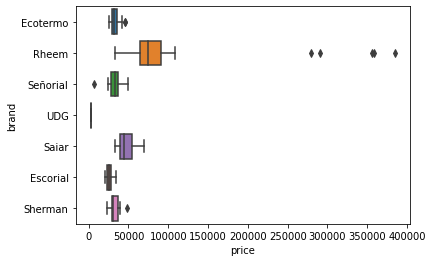

In [ ]:
# I start by analyzing the price segment in which the brands are located
 ax = sns.boxplot(x="price", y="brand", data=df_products)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


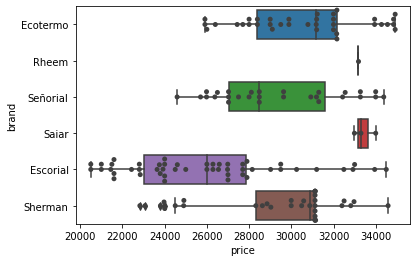

In [ ]:
# First, we can see that Rheem has a much wider price range, with some products reaching up to 120,000.
# To visualize this more precisely, let's focus on water heaters priced between 15,000 and 35,000, removing outliers.

df_products_prices = df_products[df_products['price'].between(15000, 35000)]

# Let's create the boxplot
ax = sns.boxplot(x="price", y="brand", data=df_products_prices)
ax = sns.swarmplot(x="price", y="brand", data=df_products_prices, color=".25")


Here, we can see how Escorial positions itself as a low-cost product compared to its competitors. Señorial and Ecotermo compete in the mid-range and premium segments. It seems that Señorial is aiming to capture market share from Ecotermo by setting its prices slightly lower. Rheem and Saiar compete in a higher price segment.

Text(0.5, 1.0, 'Volumen')

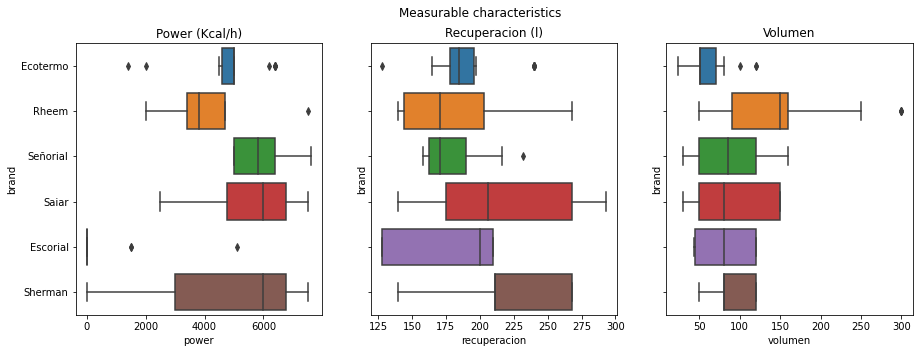

In [ ]:
# We compare numerically measurable characteristics
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Measurable Characteristics')

# Power
# Remove outliers
df_products_power = df_products.loc[(df_products['power'] < 8000)]
sns.boxplot(ax=axes[0], x="power", y="brand", data=df_products_power)
axes[0].set_title("Power (Kcal/h)")

# Recuperacion (Recovery)
df_products_recovery = df_products.loc[(df_products['recovery'] < 350)]
sns.boxplot(ax=axes[1], x="recovery", y="brand", data=df_products_recovery)
axes[1].set_title("recovery (l)")

# Energy Efficiency
# Remove outliers
df_products_weight = df_products.loc[(df_products['volume'] < 1300)]
sns.boxplot(ax=axes[2], x="volume", y="brand", data=df_products_weight)
axes[2].set_title("volume")


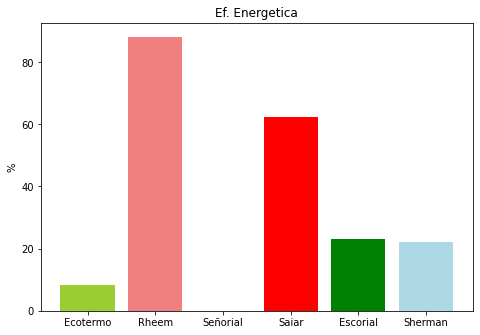

In [ ]:
# High energy efficiency
# We separate the dataframe by brand
df_products_Ecotermo     = df_products.loc[(df_products['brand'] == 'Ecotermo')]
df_products_Rheem    = df_products.loc[(df_products['brand'] == 'Rheem')]
df_products_Señorial = df_products.loc[(df_products['brand'] == 'Señorial')]
df_products_Saiar    = df_products.loc[(df_products['brand'] == 'Saiar')]
df_products_Escorial = df_products.loc[(df_products['brand'] == 'Escorial')]
df_products_Sherman = df_products.loc[(df_products['brand'] == 'Sherman')]

# Calculate the average of products with high energy efficiency by brand
df_products_Ecotermo_high_efficiency = df_products_Ecotermo['energy_efficiency'].dropna()
avg_high_efficiency_Ecotermo = (df_products_Ecotermo[df_products_Ecotermo['energy_efficiency'] == 'A'].shape[0] / df_products_Ecotermo_high_efficiency.shape[0]) * 100

df_products_Rheem_high_efficiency = df_products_Rheem['energy_efficiency'].dropna()
avg_high_efficiency_Rheem = (df_products_Rheem[df_products_Rheem['energy_efficiency'] == 'A'].shape[0] / df_products_Rheem_high_efficiency.shape[0]) * 100

df_products_Señorial_high_efficiency = df_products_Señorial['energy_efficiency'].dropna()
avg_high_efficiency_Señorial = (df_products_Señorial[df_products_Señorial['energy_efficiency'] == 'A'].shape[0] / df_products_Señorial_high_efficiency.shape[0]) * 100

df_products_Saiar_high_efficiency = df_products_Saiar['energy_efficiency'].dropna()
avg_high_efficiency_Saiar = (df_products_Saiar[df_products_Saiar['energy_efficiency'] == 'A'].shape[0] / df_products_Saiar_high_efficiency.shape[0]) * 100

df_products_Escorial_high_efficiency = df_products_Escorial['energy_efficiency'].dropna()
avg_high_efficiency_Escorial = (df_products_Escorial[df_products_Escorial['energy_efficiency'] == 'A'].shape[0] / df_products_Escorial_high_efficiency.shape[0]) * 100

df_products_Sherman_high_efficiency = df_products_Sherman['energy_efficiency'].dropna()
avg_high_efficiency_Sherman = (df_products_Sherman[df_products_Sherman['energy_efficiency'] == 'A'].shape[0] / df_products_Sherman_high_efficiency.shape[0]) * 100

# Create a bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
brands = ['Ecotermo', 'Rheem', 'Señorial', 'Saiar', 'Escorial', 'Sherman']
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'green', 'lightblue']
avg_high_efficiency = [avg_high_efficiency_Ecotermo, avg_high_efficiency_Rheem, avg_high_efficiency_Señorial, avg_high_efficiency_Saiar, avg_high_efficiency_Escorial, avg_high_efficiency_Sherman]
ax.bar(brands, avg_high_efficiency, color=colors)
plt.title('Energy Efficiency')
plt.ylabel('%')
plt.show()


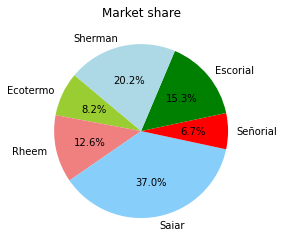

In [ ]:
# Calculate the average quantity of products sold per brand

df_products_Ecotermo = df_products.loc[(df_products['brand'] == 'Ecotermo')]
df_products_Rheem    = df_products.loc[(df_products['brand'] == 'Rheem')]
df_products_Señorial = df_products.loc[(df_products['brand'] == 'Señorial')]
df_products_Saiar    = df_products.loc[(df_products['brand'] == 'Saiar')]
df_products_Escorial = df_products.loc[(df_products['brand'] == 'Escorial')]
df_products_Sherman = df_products.loc[(df_products['brand'] == 'Sherman')]

prom_sold_days_Ecotermo  = df_products_Ecotermo['sold_quantity/diff_days'].sum()
prom_sold_days_Rheem    = df_products_Rheem['sold_quantity/diff_days'].sum()
prom_sold_days_Señorial = df_products_Señorial['sold_quantity/diff_days'].sum()
prom_sold_days_Saiar    = df_products_Saiar['sold_quantity/diff_days'].sum()
prom_sold_days_Escorial = df_products_Escorial['sold_quantity/diff_days'].sum()
prom_sold_days_Sherman = df_products_Sherman['sold_quantity/diff_days'].sum()

# Create a pie chart
labels = ['Ecotermo', 'Rheem', 'Saiar', 'Señorial', 'Escorial', 'Sherman']
prom_sold_days = [prom_sold_days_Ecotermo, prom_sold_days_Rheem, prom_sold_days_Señorial, prom_sold_days_Saiar, prom_sold_days_Escorial, prom_sold_days_Sherman]
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'green', 'lightblue']
plt.pie(prom_sold_days, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Market Share')
plt.show()
